In [1]:
# Project #1 Juypter Notebook
# Created by Melinda Eudy, Cameron Farquhar, Markita Francis, Luis Rojas, Kelly Rose
# Project : 2017 Crime Data Used from several resources ---UCR Crime Rates by County, US Census, and 

In [2]:
# Dependencies and Setup *******Review before final presentation and remove what is not needed*********
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
from datetime import date
from functools import reduce
import json
import ctypes  # An included library with Python install.
import datetime

# Import API key
#from config import apikey

In [3]:
# Part 1 - open UCR Crime Rates by County.csv file
#----------open 37059-Codebook County Codes.csv file and merge into first file to obtain County Names 
UCR_Crime = "Resources/UCR_Crime_Rate_by_County.csv"

# Read file and store in Pandas data frame
UCR_Crime_df = pd.read_csv(UCR_Crime)
UCR_Crime_df.head()
#UCR_Crime_df.count() ----all columns had same count

,FIPS_ST,FIPS_CTY,population,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,...,INDEX,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,29,510,318416,1791.995377,1,1,4,1612,318667,318667,...,5706,22329,119,200,1778,3609,4995,13791,3543,464
1,5,35,49746,1754.914968,2,1,4,130,50717,50717,...,873,3424,8,38,165,662,1482,1753,189,28
2,17,3,7629,1664.700485,3,1,4,604,8040,8040,...,127,278,1,2,5,119,82,184,12,2
3,48,261,412,1456.310680,4,1,4,2681,444,444,...,6,13,0,3,1,2,5,4,4,0
4,22,31,27083,1447.402430,5,1,4,1137,26971,26971,...,392,703,3,4,17,368,149,494,60,0


In [4]:
# FIPS-ST is the first number of the Code, FIPS_City is the last three numbers of the code.
#-----Make FIPS_City three digits wide (adding zeros in front) and combine the two columns
UCR_Crime_df["FIPS_ST"] = UCR_Crime_df["FIPS_ST"].apply(str)
UCR_Crime_df["FIPS_CTY"] = UCR_Crime_df["FIPS_CTY"].apply(str)
UCR_Crime_df["FIPS_CTY"] = UCR_Crime_df["FIPS_CTY"].apply(lambda x: x.zfill(3))
UCR_Crime_df["CODE"] = UCR_Crime_df[["FIPS_ST", "FIPS_CTY"]].agg("".join, axis=1)
UCR_Crime_df.head(15)

,FIPS_ST,FIPS_CTY,population,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,...,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,CODE
0,29,510,318416,1791.995377,1,1,4,1612,318667,318667,...,22329,119,200,1778,3609,4995,13791,3543,464,29510
1,5,035,49746,1754.914968,2,1,4,130,50717,50717,...,3424,8,38,165,662,1482,1753,189,28,5035
2,17,003,7629,1664.700485,3,1,4,604,8040,8040,...,278,1,2,5,119,82,184,12,2,17003
3,48,261,412,1456.310680,4,1,4,2681,444,444,...,13,0,3,1,2,5,4,4,0,48261
4,22,031,27083,1447.402430,5,1,4,1137,26971,26971,...,703,3,4,17,368,149,494,60,0,22031
5,24,510,622104,1419.537569,6,1,4,1227,625474,625474,...,29868,216,317,3638,4660,7804,18055,4009,251,24510
6,47,157,939465,1315.003752,7,1,4,2534,942807,942807,...,47864,135,483,3512,8224,14011,30620,3233,435,47157
7,45,069,28003,1253.437132,8,1,4,2377,28780,28780,...,1549,3,20,32,296,408,1074,67,5,45069
8,32,029,3942,1217.656012,9,1,4,1778,3947,3947,...,86,0,7,2,39,23,55,8,2,32029
9,11,001,646449,1216.801325,10,1,4,325,632323,632323,...,30757,88,236,4037,3505,3519,23575,3663,51,11001


In [5]:
# Finalize file for merging
#-----remove columns: STUDYNO, EDITION, PART, FLIPS_ST, FLIPS_CTY
#-----move Code to the front of the file - ensure that it is a int64.
UCR_Crime_df.drop(columns = ["index", "EDITION", "PART", "FIPS_ST", "FIPS_CTY"], inplace = True)
UCR_Crime_df["CODE"] = UCR_Crime_df["CODE"].apply("int64")
pd.set_option("precision",0)
collist = UCR_Crime_df.columns.tolist()
collist.insert(0, collist.pop(collist.index("CODE")))
UCR_Crime_df = UCR_Crime_df.reindex(columns = collist)

# Rename columns for better understanding
UCR_Crime_df.rename(columns={"AG_ARRST": "# COUNTY AGENCY REPORTING ARREST", "AG_OFF": "# COUNTY AGENCY REPORTING CRIME","COVIND": "COVERAGE INDICATOR"}, inplace = True)
UCR_Crime_df.rename(columns={"CPOPCRIM": "COUNTY POP - AGENCY REPORTING CRIME", "CPOPARST": "COUNTY POP - AGENCY REPORTING ARRESTS", "population": "POPULATION", "crime_rate_per_100000": "CRIME RATE PER 100k"}, inplace = True)
UCR_Crime_df.head(15)

,CODE,POPULATION,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,COVERAGE INDICATOR,INDEX,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,29510,318416,1792,1612,318667,318667,15,15,1,5706,22329,119,200,1778,3609,4995,13791,3543,464
1,5035,49746,1755,130,50717,50717,4,4,1,873,3424,8,38,165,662,1482,1753,189,28
2,17003,7629,1665,604,8040,8040,2,2,1,127,278,1,2,5,119,82,184,12,2
3,48261,412,1456,2681,444,444,1,1,1,6,13,0,3,1,2,5,4,4,0
4,22031,27083,1447,1137,26971,26971,3,3,1,392,703,3,4,17,368,149,494,60,0
5,24510,622104,1420,1227,625474,625474,9,9,1,8831,29868,216,317,3638,4660,7804,18055,4009,251
6,47157,939465,1315,2534,942807,942807,15,14,1,12354,47864,135,483,3512,8224,14011,30620,3233,435
7,45069,28003,1253,2377,28780,28780,9,8,1,351,1549,3,20,32,296,408,1074,67,5
8,32029,3942,1218,1778,3947,3947,1,1,1,48,86,0,7,2,39,23,55,8,2
9,11001,646449,1217,325,632323,632323,2,1,1,7866,30757,88,236,4037,3505,3519,23575,3663,51


In [6]:
UCR_Codes = "Resources/Codebook_County_Codes.csv"

# Read file and store in Pandas data frame
UCR_Codes_df = pd.read_csv(UCR_Codes)
#UCR_Codes_df.count()   --- all columns had the same count
UCR_Codes_df.head()

,State,Code,County,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Alabama,1001,Autauga,NaN,NaN,NaN
1,Alabama,1003,Baldwin,NaN,NaN,NaN
2,Alabama,1005,Barbour,NaN,NaN,NaN
3,Alabama,1007,Bibb,NaN,NaN,NaN
4,Alabama,1009,Blount,NaN,NaN,NaN


In [7]:
# Before mergining data:
# ------Remove Unnamed:3 - Unnamed:5
# ------Remove decimal in Code
#-------Rename Code to CODE
UCR_Codes_df.drop(columns = ["Unnamed: 3", "Unnamed: 4", "Unnamed: 5"], inplace = True)
UCR_Codes_df.rename(columns={"Code":"CODE", "State":"STATE", "County":"COUNTY"}, inplace = True)
UCR_Codes_df["CODE"] = UCR_Codes_df["CODE"].apply("int64")
pd.set_option("precision",0)
UCR_Codes_df.head(15)

,STATE,CODE,COUNTY
0,Alabama,1001,Autauga
1,Alabama,1003,Baldwin
2,Alabama,1005,Barbour
3,Alabama,1007,Bibb
4,Alabama,1009,Blount
5,Alabama,1011,Bullock
6,Alabama,1013,Butler
7,Alabama,1015,Calhoun
8,Alabama,1017,Chambers
9,Alabama,1019,Cherokee


In [8]:
# Merge Codebook_County_Codes.csv into UCR_Crime_Rates_by_County.csv
merged_UCR_Crime_df = pd.merge(UCR_Codes_df, UCR_Crime_df,on="CODE")
merged_UCR_Crime_df.head(15)
#merged_UCR_Crime_df.dtypes

,STATE,CODE,COUNTY,POPULATION,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,...,INDEX,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,Alabama,1001,Autauga,55246,252,1,57161,54604,3,3,...,139,1765,3,15,34,87,447,1233,85,108
1,Alabama,1003,Baldwin,195540,228,2,187467,187467,14,14,...,446,4988,8,30,76,332,967,3829,192,31
2,Alabama,1005,Barbour,27076,177,3,27228,25566,6,4,...,48,474,0,4,8,36,90,362,21,0
3,Alabama,1007,Bibb,22512,218,4,22907,22857,5,6,...,49,399,1,4,8,36,122,251,27,0
4,Alabama,1009,Blount,57872,211,5,57909,57909,6,6,...,122,1347,1,11,9,101,397,865,86,9
5,Alabama,1011,Bullock,10639,526,6,10584,10584,2,2,...,56,156,0,2,12,43,98,55,3,23
6,Alabama,1013,Butler,20265,538,7,20741,20733,4,4,...,109,621,6,5,11,87,182,408,30,3
7,Alabama,1015,Calhoun,116736,581,8,122213,118270,8,10,...,678,5339,6,37,131,504,1710,3482,147,34
8,Alabama,1017,Chambers,34162,562,9,34075,34075,4,4,...,192,1345,1,7,24,160,374,875,96,5
9,Alabama,1019,Cherokee,26203,416,10,26141,26162,4,5,...,109,1014,1,4,2,102,329,610,75,12


In [9]:
# Bring in data from the US census per couounty
# adding median income per county
response = requests.get("https://api.census.gov/data/2017/acs/acs1?get=NAME,B06011_001E&for=county:*").json()
# locate the first row and make it the column name and then drop row 0
income_df = pd.DataFrame(response)
income_df.columns = income_df.iloc[0]
income_df = income_df.drop([1])

# delete and null info and reset the index
income_df = income_df.dropna(how='any')
income_df.reset_index()

#replace the integer column names with values in row 0
income_df.columns = income_df.iloc[0]
income_df = income_df.drop([0])
income_df.reset_index()
income_df.head(15)
#income_df.dtypes

,NAME,B06011_001E,state,county
2,"Calhoun County, Alabama",26121,01,015
3,"Cullman County, Alabama",22692,01,043
4,"DeKalb County, Alabama",21581,01,049
5,"Elmore County, Alabama",28967,01,051
6,"Etowah County, Alabama",19861,01,055
7,"Houston County, Alabama",25153,01,069
8,"Jefferson County, Alabama",27868,01,073
9,"Lauderdale County, Alabama",24553,01,077
10,"Lee County, Alabama",24827,01,081
11,"Limestone County, Alabama",26674,01,083


In [10]:
# create new columns for County and State
# ----Remove Columns: NAME, state, county
#-----Change column names to match merged UCR Crime data
#-----Remove word "County" in County name
income_df['County Name'] = income_df['NAME'].str.split(', ').apply(lambda x: x[0])
income_df['State Name'] = income_df['NAME'].str.split(', ').apply(lambda x: x[-1])
income_df['County Name'] = income_df['NAME'].str.split(' ').apply(lambda x: x[0])
income_df.drop(columns = ["NAME", "state", "county"], inplace = True)
income_df.rename(columns={"County Name":"COUNTY", "State Name":"STATE", "B06011_001E":"MEDIAN INCOME"}, inplace = True)
# Clean up formating in Median Income
income_df["MEDIAN INCOME"] = income_df["MEDIAN INCOME"].apply("int64")
income_df.head(15)
#income_df.dtypes

,MEDIAN INCOME,COUNTY,STATE
2,26121,Calhoun,Alabama
3,22692,Cullman,Alabama
4,21581,DeKalb,Alabama
5,28967,Elmore,Alabama
6,19861,Etowah,Alabama
7,25153,Houston,Alabama
8,27868,Jefferson,Alabama
9,24553,Lauderdale,Alabama
10,24827,Lee,Alabama
11,26674,Limestone,Alabama


In [11]:
# Merge Census Median Income into UCR_Crime_Rates_by_County.csv
# Move Median Income to front of chart
Crime_df = pd.merge(merged_UCR_Crime_df, income_df, on=["STATE", "COUNTY"], how="left" )
collist = Crime_df.columns.tolist()
collist.insert(4, collist.pop(collist.index("MEDIAN INCOME")))
Crime_df = Crime_df.reindex(columns = collist)

# delete and null info and reset the index
Crime_df = Crime_df.dropna(how='any')
Crime_df.head(15)

,STATE,CODE,COUNTY,POPULATION,MEDIAN INCOME,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,...,INDEX,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
7,Alabama,1015,Calhoun,116736,26121,581,8,122213,118270,8,...,678,5339,6,37,131,504,1710,3482,147,34
21,Alabama,1043,Cullman,80811,22692,238,22,80832,80859,3,...,192,2065,2,16,13,161,483,1483,99,6
25,Alabama,1051,Elmore,80902,28967,284,26,80528,80484,7,...,230,2117,4,23,44,159,665,1367,85,14
27,Alabama,1055,Etowah,103931,19861,514,28,103809,97544,10,...,534,4209,2,45,126,361,1241,2674,294,42
34,Alabama,1069,Houston,103668,25153,401,35,103678,102780,9,...,416,3659,7,42,108,259,1095,2380,184,18
36,Alabama,1073,Jefferson,659479,27868,798,37,686887,659396,31,...,5265,31530,85,268,1597,3315,9910,19810,1809,185
38,Alabama,1077,Lauderdale,92797,24553,263,39,93154,93154,8,...,244,2312,3,28,55,157,612,1600,100,6
40,Alabama,1081,Lee,150933,24827,246,41,139698,144044,3,...,372,4024,8,26,77,261,954,2942,128,9
41,Alabama,1083,Limestone,88845,26674,152,42,80471,85712,3,...,135,1599,4,2,25,104,398,1146,56,0
44,Alabama,1089,Madison,346892,31755,603,45,346631,341477,11,...,2093,12692,18,107,523,1445,3217,8556,919,33


In [12]:
# Bring in data from the US census per county
#------population density per county
#------median income per county
response = requests.get(f'https://api.census.gov/data/2017/pep/population?get=POP,DENSITY&for=county:*').json()

# locate the first row and make it the column name and then drop row 0
county_dens_df = pd.DataFrame(response)
county_dens_df.columns = county_dens_df.iloc[0]
county_dens_df = county_dens_df.drop([0])

county_dens_df["state"] = county_dens_df["state"].apply(str)
county_dens_df["county"] = county_dens_df["county"].apply(str)
county_dens_df["county"] = county_dens_df["county"].apply(lambda x: x.zfill(3))
county_dens_df["CODE"] = county_dens_df[["state", "county"]].agg("".join, axis=1)

# delete and null info and reset the index
county_dens_df = county_dens_df.dropna(how='any')
county_dens_df.head(15)

,POP,DENSITY,state,county,CODE
1,12469,14.666355113,01,035,01035
2,10754,16.521468381,01,037,01037
3,37092,35.995681469,01,039,01039
4,13871,22.781736369,01,041,01041
5,82755,112.62558771,01,043,01043
6,49226,87.727091151,01,045,01045
7,39215,40.067790704,01,047,01047
8,55504,93.37056512,01,001,01001
9,212628,133.74373093,01,003,01003
10,25270,28.553606592,01,005,01005


In [13]:
# create new columns for County and State
# ----Remove Columns: NAME, state, county
#-----Change column names to match merged UCR Crime data
#-----Remove word "County" in County name
# county_dens_df['County Name'] = county_dens_df['NAME'].str.split(', ').apply(lambda x: x[0])
# county_dens_df['State Name'] = county_dens_df['NAME'].str.split(', ').apply(lambda x: x[-1])
# county_dens_df['County Name'] = county_dens_df['NAME'].str.split(' ').apply(lambda x: x[0])

county_dens_df.drop(columns = ["state", "county"], inplace = True)
county_dens_df.rename(columns={"POP": "POPULATION"}, inplace = True)
county_dens_df["POPULATION"] = county_dens_df["POPULATION"].apply("int64")
county_dens_df["CODE"] = county_dens_df["CODE"].apply("int64")
county_dens_df["DENSITY"] = county_dens_df["DENSITY"].apply(lambda x: float(x))
county_dens_df["DENSITY"] = round(county_dens_df["DENSITY"],2)
county_dens_df.head()

,POPULATION,DENSITY,CODE
1,12469,15,1035
2,10754,17,1037
3,37092,36,1039
4,13871,23,1041
5,82755,113,1043


In [14]:
# Merge Codebook_County_Codes.csv into UCR_Crime_Rates_by_County.csv
# Move Density and Population to front of chart
merged_Crime_df = pd.merge(Crime_df, county_dens_df, on=["CODE"], how = "right")
collist = merged_Crime_df.columns.tolist()
collist.insert(4, collist.pop(collist.index("DENSITY")))
# collist.insert(5, collist.pop(collist.index("POPULATION")))
merged_Crime_df = merged_Crime_df.reindex(columns = collist)

# delete and null info and reset the index
merged_Crime_df = merged_Crime_df.dropna(how='any')
merged_Crime_df.reset_index()
merged_Crime_df.head(15)


,STATE,CODE,COUNTY,POPULATION_x,DENSITY,MEDIAN INCOME,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,...,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,POPULATION_y
0,Alabama,1015,Calhoun,116736,189,26121,581,8,122213,118270,...,5339,6,37,131,504,1710,3482,147,34,114728
1,Alabama,1043,Cullman,80811,113,22692,238,22,80832,80859,...,2065,2,16,13,161,483,1483,99,6,82755
2,Alabama,1051,Elmore,80902,132,28967,284,26,80528,80484,...,2117,4,23,44,159,665,1367,85,14,81677
3,Alabama,1055,Etowah,103931,192,19861,514,28,103809,97544,...,4209,2,45,126,361,1241,2674,294,42,102755
4,Alabama,1069,Houston,103668,180,25153,401,35,103678,102780,...,3659,7,42,108,259,1095,2380,184,18,104346
5,Alabama,1073,Jefferson,659479,593,27868,798,37,686887,659396,...,31530,85,268,1597,3315,9910,19810,1809,185,659197
6,Alabama,1077,Lauderdale,92797,138,24553,263,39,93154,93154,...,2312,3,28,55,157,612,1600,100,6,92538
7,Alabama,1081,Lee,150933,266,24827,246,41,139698,144044,...,4024,8,26,77,261,954,2942,128,9,161604
8,Alabama,1083,Limestone,88845,169,26674,152,42,80471,85712,...,1599,4,2,25,104,398,1146,56,0,94402
9,Alabama,1089,Madison,346892,450,31755,603,45,346631,341477,...,12692,18,107,523,1445,3217,8556,919,33,361046


In [15]:
merged_Crime_df.describe()

,CODE,POPULATION_x,DENSITY,MEDIAN INCOME,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,...,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,POPULATION_y
count,728,7e+02,728,728,728,728,7e+02,7e+02,728,728,...,728,728,728,728,728,728,728,728,728,7e+02
mean,30492,3e+05,702,29782,318,1585,3e+05,3e+05,13,12,...,8921,14,82,372,747,2080,6135,706,53,3e+05
std,15366,5e+05,2358,6164,207,929,5e+05,5e+05,13,12,...,15793,38,122,1088,1514,3708,10524,1824,101,5e+05
min,1015,9e+03,4,16246,11,8,9e+03,9e+03,1,1,...,65,0,0,0,1,9,41,5,0,9e+03
25%,17176,9e+04,140,25582,166,690,9e+04,9e+04,6,5,...,2295,2,22,29,128,520,1612,96,10,9e+04
50%,34036,2e+05,266,28926,267,1810,1e+05,1e+05,9,8,...,4076,4,41,73,280,968,2910,192,22,2e+05
75%,42078,3e+05,522,32261,429,2308,3e+05,3e+05,16,14,...,8722,11,87,232,671,1934,6311,478,51,3e+05
max,56025,5e+06,38182,66404,1315,3167,5e+06,5e+06,150,140,...,178681,566,1143,15583,16290,43644,115634,20829,1153,5e+06


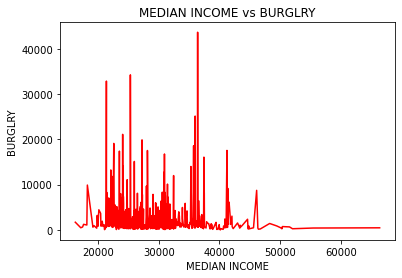

In [16]:
x_axis = merged_Crime_df["MEDIAN INCOME"].sort_values()
y_axis = merged_Crime_df["BURGLRY"]

# x_axis = np.arange(x_dens.min(),x_dens.max(),100)

plt.plot(x_axis, y_axis, color="red")


plt.title("MEDIAN INCOME vs BURGLRY")
plt.xlabel("MEDIAN INCOME")
plt.ylabel("BURGLRY")

# plt.xlim(0,120)
# plt.xlim(0,1500)
plt.show()

In [17]:
merged_Crime_df.columns

Index(['STATE', 'CODE', 'COUNTY', 'POPULATION_x', 'DENSITY', 'MEDIAN INCOME',
       'CRIME RATE PER 100k', 'IDNO', 'COUNTY POP - AGENCY REPORTING ARRESTS',
       'COUNTY POP - AGENCY REPORTING CRIME',
       '# COUNTY AGENCY REPORTING ARREST', '# COUNTY AGENCY REPORTING CRIME',
       'COVERAGE INDICATOR', 'INDEX', 'MODINDX', 'MURDER', 'RAPE', 'ROBBERY',
       'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON', 'POPULATION_y'],
      dtype='object')

the r-value is: 0.20531318837701037


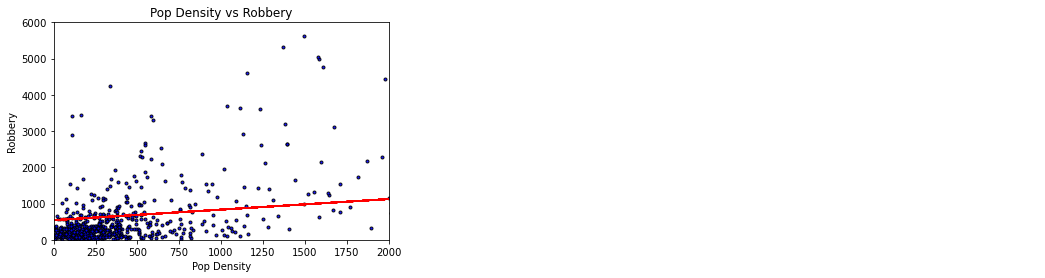

In [18]:
x_values = merged_Crime_df["DENSITY"]
y_values = merged_Crime_df["AGASSLT"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values, marker=".", facecolors="blue", edgecolors="black", alpha=0.90)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(5000, 100), fontsize=15,color="red")

plt.title("Pop Density vs Robbery")
plt.xlabel("Pop Density")
plt.ylabel("Robbery")

plt.xlim(0, 2000)
plt.ylim(0, 6000)

print(f'the r-value is: {rvalue**2}')

the r-value is: 0.09389487341556554


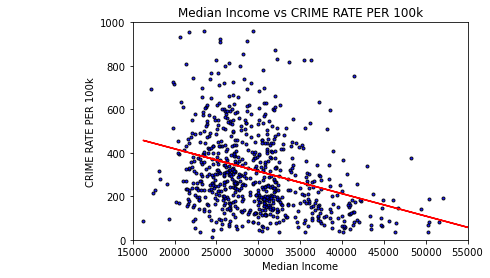

In [19]:
x_values = merged_Crime_df["MEDIAN INCOME"]
y_values = merged_Crime_df["CRIME RATE PER 100k"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values, marker=".", facecolors="blue", edgecolors="black", alpha=0.90)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(0, 0), fontsize=15,color="red")

plt.title("Median Income vs CRIME RATE PER 100k")
plt.xlabel("Median Income")
plt.ylabel("CRIME RATE PER 100k")

plt.xlim(15000, 55000)
plt.ylim(0, 1000)

print(f'the r-value is: {rvalue**2}')